In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt

import json
import random
from collections import defaultdict
from collections import Counter
from nltk.corpus import stopwords

In [2]:
file='aggressive_dedup.json'
with open(file) as infile:
    for line in infile:
        data = json.loads(line)
        print(data)
        break

{'helpful': [0, 0], 'reviewTime': '11 21, 2012', 'unixReviewTime': 1353456000, 'reviewerID': 'A00000262KYZUE4J55XGL', 'reviewerName': 'Steven N Elich', 'overall': 5.0, 'summary': "Does what it's supposed to do", 'asin': 'B003UYU16G', 'reviewText': "It is and does exactly what the description said it would be and would do. Couldn't be happier with it."}


In [3]:
def get_data(file='aggressive_dedup.json', year='2001', limit=100000000, size=10000):
    data = defaultdict(list)
    time = defaultdict(list)
    ratings = defaultdict(list)
    seen = {}
    
    with open(file) as infile:
        i = 0
        for line in infile:
            x = json.loads(line)
            yr = x['reviewTime'][-4:]
            rt = int(x.get('overall'))
            if yr >= year:
                if yr not in seen:
                    seen[yr] = 1
                else:
                    seen[yr] += 1
                if len(data[yr]) < size:
                    data[yr].append(x.get('reviewText'))
                    time[yr].append(x.get('reviewTime'))
                    ratings[yr].append(rt)
                else:
                    if np.random.uniform() < size/seen[yr]:
                        p = np.random.randint(size)
                        data[yr][p] = x.get('reviewText')
                        time[yr][p] = x.get('reviewTime')
                        ratings[yr][p] = rt            
            i += 1
            if i > limit:
                break
    return data, time, ratings, seen

def binarify(val):
    if 4 > val:
        return 0
    else:
        return 1

def simplify_ratings(data, ratings):
    keys = sorted(list(ratings.keys()))
    for key in keys:
        ratings[key] = [binarify(x) for x in ratings.get(key)]
    return ratings

def save_file(filename, data):
    with open(filename, "wb") as fp:
        pickle.dump(data, fp)

def load_file(filename):
    with open(filename, "rb") as fp:
        data = pickle.load(fp)
    return data

In [5]:
size = 40000
data, time, ratings, seen = get_data(size=size)
ratings_b = simplify_ratings(data, ratings)

for key in data.keys():
    print(key, '>>>', len(data[key]))

2012 >>> 1000
2005 >>> 1000
2003 >>> 1000
2007 >>> 1000
2008 >>> 1000
2011 >>> 1000
2006 >>> 1000
2010 >>> 1000
2004 >>> 1000
2002 >>> 1000
2001 >>> 1000
2014 >>> 1000
2009 >>> 1000
2013 >>> 1000


In [6]:
def stopwords_filter(data):
    stop_words = set(stopwords.words('english'))
    x = sorted(list(data.keys()))
    for key in x:
        for i, m in enumerate(data[key]):
            data[key][i] = ' '.join( (w for w in m.split() if w not in stop_words) )
    return data

"""print(data['2005'][0])
data2 = stopwords_filter(data)
print(data['2005'][0])"""

"print(data['2005'][0])\ndata2 = stopwords_filter(data)\nprint(data['2005'][0])"

In [7]:
x = sorted(list(data.keys()))
for each in x:
    print(np.round(np.array(list((Counter(ratings[each]).values())))/len(ratings[each]), 2))

[ 0.18  0.82]
[ 0.19  0.81]
[ 0.22  0.78]
[ 0.22  0.78]
[ 0.25  0.75]
[ 0.22  0.78]
[ 0.22  0.78]
[ 0.22  0.78]
[ 0.25  0.75]
[ 0.24  0.76]
[ 0.23  0.77]
[ 0.28  0.72]
[ 0.21  0.79]
[ 0.2  0.8]


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [9]:
LR = LogisticRegression(penalty='l1', n_jobs=-1, solver='saga', max_iter=300)
#LR = LogisticRegression(penalty='l1', n_jobs=-1, solver='saga', max_iter=100, class_weight='balanced')

CV = CountVectorizer(ngram_range=(1,2), analyzer='word')#, max_features=20000)

features = []

In [10]:
def split_eighty_twenty(n):
    indices = np.random.permutation(n)
    threshold = int(np.floor(n*0.8))
    return indices[:threshold], indices[threshold:]

def test_train(data, ratings_b):
    train_idx, test_idx = split_eighty_twenty(len(data))
    X_train, X_test = np.array(data)[train_idx], np.array(data)[test_idx]
    y_train, y_test = np.array(ratings_b)[train_idx], np.array(ratings_b)[test_idx]
    return X_train, X_test, y_train, y_test

def predict_scores(data, ratings_b, CV, LR, i):   
    X_train, X_test, y_train, y_test = test_train(data, ratings_b)

    if i == 0:
        X_train = CV.fit_transform(X_train)
        X_test = CV.transform(X_test)
        features[:] = list(CV.get_feature_names())
    else:
        X_train = CV.transform(X_train)
        X_test = CV.transform(X_test)

    LR.fit(X_train,y_train)
    y_pred = LR.predict(X_test)
    print(LR.score(X_test, y_test))
    print('f1:', f1_score(y_test, y_pred, pos_label=1, average=None))
    print('recall:', recall_score(y_test, y_pred, pos_label=1, average=None))
    print('precision:', precision_score(y_test, y_pred, pos_label=1, average=None))
    print()
    return LR, CV

In [11]:
x = sorted(list(data.keys()))
for i, key in enumerate(x):
    LR, CV = predict_scores(data[key], ratings_b[key], CV, LR, i)
    save_file('models/LR_' + str(key) + '_' + str(size) + '.model', LR)
    if i == 0:
        top_f = [[x,[len(features)-i]] for i, (_,x) in enumerate(sorted(zip(LR.coef_[0],features)))][:-300:-1]
        bot_f = [[x,[i+1]] for i, (_,x) in enumerate(sorted(zip(LR.coef_[0],features)))][:300]
    else:
        for i, m in enumerate(top_f):
            top_f[i][1] += [len(features)-i for i, (_,x) in enumerate(sorted(zip(LR.coef_[0],features))) if x == m[0]]
        for i, m in enumerate(bot_f):
            bot_f[i][1] += ([i+1 for i, (_,x) in enumerate(sorted(zip(LR.coef_[0],features))) if x == m[0]])
    save_file('metrics/LR_' + str(key) + '_' + str(size) + '.top', top_f)
    save_file('metrics/LR_' + str(key) + '_' + str(size) + '.bot', bot_f)
    #break

D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.775
f1: [ 0.32835821  0.86486486]
recall: [ 0.30555556  0.87804878]
precision: [ 0.35483871  0.85207101]

0.8
f1: [ 0.33333333  0.88235294]
recall: [ 0.22727273  0.96153846]
precision: [ 0.625       0.81521739]

0.825
f1: [ 0.42622951  0.89675516]
recall: [ 0.39393939  0.91017964]
precision: [ 0.46428571  0.88372093]

0.79
f1: [ 0.43243243  0.87116564]
recall: [ 0.31372549  0.95302013]
precision: [ 0.69565217  0.80225989]

0.68
f1: [ 0.33333333  0.78947368]
recall: [ 0.25        0.88235294]
precision: [ 0.5         0.71428571]

0.805
f1: [ 0.33898305  0.8856305 ]
recall: [ 0.23809524  0.9556962 ]
precision: [ 0.58823529  0.82513661]

0.73
f1: [ 0.20588235  0.8373494 ]
recall: [ 0.15909091  0.89102564]
precision: [ 0.29166667  0.78977273]

0.76
f1: [ 0.29411765  0.85542169]
recall: [ 0.29411765  0.85542169]
precision: [ 0.29411765  0.85542169]

0.79
f1: [ 0.475    0.86875]
recall: [ 0.42222222  0.89677419]
precision: [ 0.54285714  0.84242424]

0.785
f1: [ 0.51685393  0.86173633]
recal

In [12]:
for i in range(len(x)):
    print(sum([1/x[1][i] for x in top_f])/len(top_f))

0.021001105508248057
0.013934538320096551
0.014550998013108253
0.014117020530481446
0.014584196070278709
0.014175545137364418
0.012672553270001968
0.012710398366298113
0.013441174267645047
0.013189509460262134
0.014482280014923275
0.013105473498922852
0.01362149537094054
0.013670945365126239


In [13]:
for i in range(len(x)):
    print(sum([1/x[1][i] for x in bot_f])/len(bot_f))

0.020942212934331673
0.00889474054785475
0.00994501561070268
0.01087588001851172
0.012441232804555148
0.0123735752107202
0.010448376913168895
0.010390998574581195
0.010969375583755084
0.010024550665637028
0.00920653224992092
0.009853709168588062
0.009126177566142896
0.007355102541128544


In [24]:
#print(CV.vocabulary_.get('boring'))
#def important_features():
temp = [x for x in list(np.where(LR2.coef_ > 0.03))][1]
temp2 = np.zeros(len(LR2.coef_[0]))
temp2[temp] = 1
CV.inverse_transform(temp2)

[array(['absolutely', 'album', 'all', 'all the', 'also', 'always', 'am',
        'amazing', 'an', 'and', 'and is', 'anyone', 'anyone who', 'are',
        'at the', 'awesome', 'beautiful', 'being', 'best', 'book', 'books',
        'by', 'can', 'can wait', 'case', 'cd', 'characters', 'clean',
        'comfortable', 'day', 'definitely', 'down', 'each', 'easy',
        'easy to', 'enjoy', 'enjoyed', 'ever', 'everything', 'exactly',
        'exactly what', 'excellent', 'fantastic', 'far', 'fast', 'favorite',
        'fits', 'for', 'for my', 'for the', 'fun', 'gift', 'glad', 'good',
        'good quality', 'great', 'happy', 'happy with', 'has', 'heavy',
        'helps', 'highly', 'highly recommend', 'him', 'his', 'home', 'how',
        'husband', 'in', 'is', 'is great', 'is the', 'issues', 'it down',
        'it is', 'it works', 'job', 'keep', 'keeps', 'light', 'little',
        'looking', 'love', 'love it', 'love the', 'love this', 'loved',
        'loved it', 'loves', 'loves it', 'make', '

['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014'] [79944, 82750, 87948, 105154, 144502, 159232, 241791, 275799, 352714, 461740, 731465, 1389066, 3394115, 2376696]


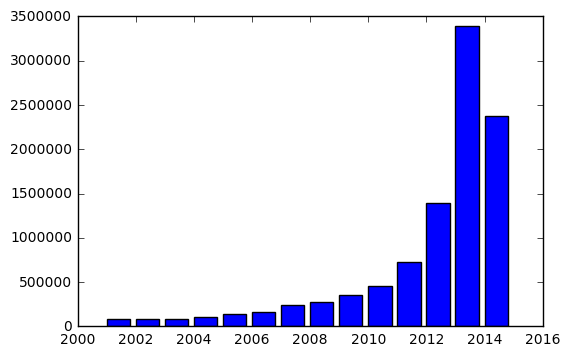

In [10]:
x = sorted(list(data.keys()))
y = [seen.get(yr) for yr in x]

print(x, y)

plt.bar(x, y)
plt.show()

In [26]:
0.05229674260242041
0.04466093736383697
0.041246644336741155
0.04436821107736982
0.043771343985104655
0.043938054233488656
0.04301488733617493
0.042890886755929364
0.04293063117143191
0.03930609407453662
0.04011972861174232
0.03983288092625466
0.038464989444320676
0.03933764204026648


0.05187377517639621
0.0419466582555003
0.04236477657775657
0.043596386131456936
0.039214832698759236
0.042987364768805596
0.04350434047806224
0.039924124582373835
0.04313042796498879
0.03682041207471429
0.03939157802085965
0.03739049389522036
0.03612349216990129
0.035323462450434225

0.035323462450434225